# SSAA Parameter Requirements

Use Megan's dfmux_calc to define simplified SQUID requirement for Stephen Boyd's design work.

First, we have to install all the required packages. For instance,
```
conda install -c conda-forge ngspice-lib # optional
conda install -c conda-forge pyspice
pyspice-post-installation --check-install
```
We will also need Megan's code `dfmux_calc`, which you can clone or download from https://github.com/megan-russell/dfmux_calc (currently private).

I've found I needed to manually add some paths in order to get it to run:

In [1]:
import sys
import os
import sys
from pathlib import Path
# home_dir = str(Path.home())
# dropbox_dir = os.path.join(home_dir, 'Dropbox', 'Memos and Microanalyses', 'TES_modeling_2022')
# sys.path.append(os.path.join(dropbox_dir, 'dfmux_calc'))
# sys.path.append(os.path.join(dropbox_dir, 'dfmux_calc', 'stcr', 'm1_spice_100mK'))
sys.path.append(os.path.join('stcr', 'm1_spice_100mK'))
import numpy as np
import matplotlib.pyplot as plt
import nep_calc
import dfmux_calc
from config import saa, bolo, wh, para, nuller_cold, psat_factor
import PySpice

In [2]:
def print_attributes(obj, indent=0, seen=None):
    if seen is None:
        seen = set()

    # Avoid revisiting the same object to prevent infinite recursion
    if id(obj) in seen:
        print(" " * indent + str(obj) + ": <Already Visited>")
        return
    seen.add(id(obj))

    # Iterate over all attributes of the object
    for attr in dir(obj):
        try:
            # Skip built-in attributes
            if attr.startswith("__"):
                continue
            value = getattr(obj, attr)
            print(" " * indent + str(attr) + ": ", end="")
            # If the attribute is a basic data type, print it directly
            if not hasattr(value, '__dict__') and not isinstance(value, (list, tuple, dict, set)):
                print(value)
            else:
                print()
                # Recursively print attributes of the attribute
                print_attributes(value, indent + 4, seen)
        except Exception as e:
            print("<Error on accessing attribute: {}>".format(e))

In [3]:
lb = nep_calc.experiment('litebird', 0) #loading definitions about bands

band = 0
# nep_readout_req = np.sqrt(lb.ntot[band]**2 - lb.rreq[band]**2)  * np.sqrt((1+frac)**2 - 1)
# vbias = np.sqrt( (rbolo + rstray) * (psat - popt) )
# resp = np.sqrt(2) / vbias * bolo.loopgain / (1 + bolo.loopgain * (rbolo - rstray)/(rbolo + rstray ) )
# loop_atten = (rbolo - rstray)/(rbolo + rstray )
dfm = dfmux_calc.dfmux_noise(saa,bolo,wh,para,nuller_cold=nuller_cold)
dfm.bolo.r = 0.7
dfm.bolo.rstray = 0.07
dfm.bolo.popt = popt = lb.popt[band] #optical power in the band of interest
dfm.bolo.psat = 2.5 * popt * psat_factor    #saturation power in the band
dfm.bolo.tb = 0.100
dfm.bolo.tc = 0.170
dfm.bolo.loopgain = 10

def calculate_nei(zt=800., rdyn=300., lin=15e-9, inoise=2.5e-12, frequency=4e6): 
    dfm.squid.zt = zt
    dfm.squid.rdyn = rdyn 
    dfm.squid.lin = lin 
    dfm.squid.inoise = inoise 
    dfm.init_freq(frequencies=np.array([frequency]), skip_spice=False) 
    return dfm.total*1e12 # in pA/rtHz
calculate_nei()

Unsupported Ngspice version 38


array([6.83468627])

In [4]:
#print_attributes(dfm)
#calculate_nei()

Text(0, 0.5, 'NEI at 4 MHz (pA/rtHz)')

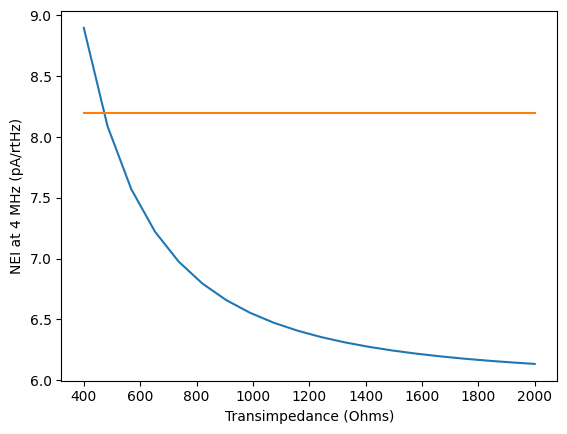

In [5]:
npts = 20
zt_arr = np.linspace(400,2000, npts)
nei_4MHz = [calculate_nei(zt=zt) for zt in zt_arr]
plt.plot(zt_arr, nei_4MHz)
plt.plot(zt_arr, np.ones(npts)*8.2)
plt.xlabel('Transimpedance (Ohms)')
plt.ylabel('NEI at 4 MHz (pA/rtHz)')

Text(0, 0.5, 'NEI at 4 MHz (pA/rtHz)')

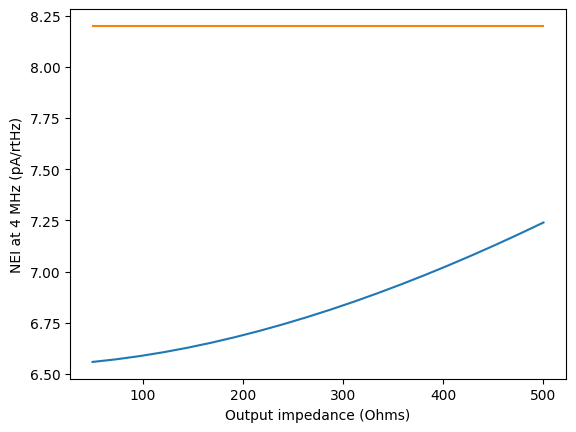

In [6]:
npts = 20
rdyn_arr = np.linspace(50,500, npts)
nei_4MHz = [calculate_nei(rdyn=rdyn) for rdyn in rdyn_arr]
plt.plot(rdyn_arr, nei_4MHz)
plt.plot(rdyn_arr, np.ones(npts)*8.2)
plt.xlabel('Output impedance (Ohms)')
plt.ylabel('NEI at 4 MHz (pA/rtHz)')

Text(0, 0.5, 'NEI at 4 MHz (pA/rtHz)')

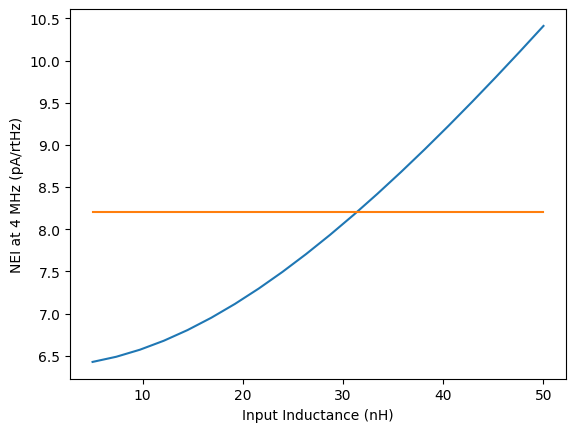

In [7]:
lin_arr = np.linspace(5,50, npts)
nei_4MHz = [calculate_nei(lin=lin*1e-9) for lin in lin_arr]
plt.plot(lin_arr, nei_4MHz)
plt.plot(lin_arr, np.ones(npts)*8.2)
plt.xlabel('Input Inductance (nH)')
plt.ylabel('NEI at 4 MHz (pA/rtHz)')

Text(0, 0.5, 'NEI at 4 MHz (pA/rtHz)')

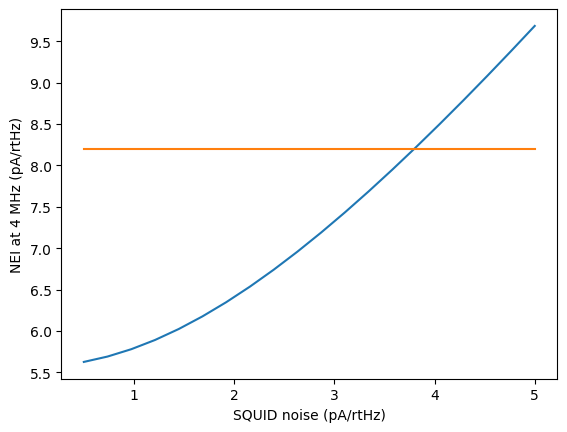

In [8]:
inoise_arr = np.linspace(0.5,5, npts)
nei_4MHz = [calculate_nei(inoise=inoise*1e-12) for inoise in inoise_arr]
plt.plot(inoise_arr, nei_4MHz)
plt.plot(inoise_arr, np.ones(npts)*8.2)
plt.xlabel('SQUID noise (pA/rtHz)')
plt.ylabel('NEI at 4 MHz (pA/rtHz)')

In [9]:
zt = 800.
ratio = calculate_nei(zt=zt*1.05)/calculate_nei(zt=zt)
alpha_zt = (ratio-1)/0.05

rdyn = 300.
ratio = calculate_nei(rdyn=rdyn*1.05)/calculate_nei(rdyn=rdyn)
alpha_rdyn = (ratio-1)/0.05

lin = 15e-9
ratio = calculate_nei(lin=lin*1.05)/calculate_nei(lin=lin)
alpha_lin = (ratio-1)/0.05

inoise = 2.5e-12
ratio = calculate_nei(inoise=inoise*1.05)/calculate_nei(inoise=inoise)
alpha_inoise = (ratio-1)/0.05

print(alpha_zt)
print(alpha_rdyn)
print(alpha_lin)
print(alpha_inoise)

[-0.21647347]
[0.07424961]
[0.13329038]
[0.34137402]


In [10]:
nei_formula = lambda zt,zdyn,lin,sqn: 8.2 * (zt/800.)**alpha_zt * (zdyn/300.)**alpha_rdyn * (lin/15e-9)**alpha_lin * (sqn/2.5e-12)**alpha_inoise

In [11]:
nei_formula(800,300,15e-9,2.5e-12)

array([8.2])

The requirement is 
$$\mathrm{NEI}_\mathrm{4 MHz} < 8.2 \mathrm{pA/rtHz} (Z_\mathrm{trans}/800 \Omega)^{-0.27} (Z_\mathrm{out}/300 \Omega)^{0.09} (L_\mathrm{in}/15 \mathrm{nH})^{0.23} (\mathrm{NEI}_\mathrm{SSAA}/2.5 \mathrm{pA/rtHz})^{0.42} $$

### Baseline "compromise" equation (TTScore)

Tucker and I disagreed on the details of this calculation. The primary sticking point was that I thought the metric should be evaluated at 4 MHz, while Tucker thought the 1.6 MHz performance more important. 

However, we somewhat coincidentally agreed that the nominal parameters (800,300,15,2.5) were at the edge of acceptable for LiteBIRD.

We therefore decided on the following "compromise" equation that we set as the tentative LiteBIRD requirement.

$$(Z_\mathrm{trans}/800 \Omega)^{-1} (Z_\mathrm{out}/300 \Omega)^{0.18} (L_\mathrm{in}/15 \mathrm{nH})^{0.47} (\mathrm{NEI}_\mathrm{SSAA}/2.5 \mathrm{pA/rtHz})^{1.24} < 1$$

### 2023-12-15 Evaluate new designs

In [13]:
# 1b design
calculate_nei(zt=296.,rdyn=141.8,lin=17.6e-9,inoise=1.16e-12)

array([9.34612814])

In [14]:
# 2b design
calculate_nei(zt=300.,rdyn=120.3,lin=13.0e-9,inoise=1.36e-12)

array([8.74444643])

In [15]:
# 5b design
calculate_nei(zt=348.,rdyn=105.4,lin=6.18e-9,inoise=2.05e-12)

array([7.81995141])

In [16]:
# 1u design
calculate_nei(zt=440.5,rdyn=99.5,lin=8.65e-9,inoise=2.21e-12)

array([7.18203324])

In [17]:
# 2u design
calculate_nei(zt=415.,rdyn=102.1,lin=8.03e-9,inoise=2.14e-12)

array([7.29779072])

In [18]:
# 5u design
calculate_nei(zt=434.,rdyn=139.5,lin=8.34e-9,inoise=2.08e-12)

array([7.2191502])

In [19]:
# 75 nW 5b design
calculate_nei(zt=1862.,rdyn=563.9,lin=33.1e-9,inoise=0.88e-12)

array([5.51754871])

The 75 nW 5b design looks very good.